### How To Implement Simple Linear Regression From Scratch With Python
https://machinelearningmastery.com/implement-simple-linear-regression-scratch-python/

In [1]:
from csv import reader

def load_csv(filename):
    dataset = list()
    with open(filename, 'r') as file:
        csv_reader = reader(file)
        for row in csv_reader:
            #if not row:
            #    continue
            dataset.append(row)
    return dataset

dataset = load_csv('diabetes.csv')

Remove column header and convert all the columns to float. 

In [2]:
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

col_names = dataset[0]
dataset.pop(0)

for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)


In [3]:
def dataset_minmax(dataset):
    minmax = list()
    for i in range(len(dataset[0])):
        col_values = [row[i] for row in dataset]
        min_value = min(col_values)
        max_value = max(col_values)
        minmax.append([min_value,max_value])
    return minmax

minmax_data = dataset_minmax(dataset)
minmax_data


[[0.0, 17.0],
 [0.0, 199.0],
 [0.0, 122.0],
 [0.0, 99.0],
 [0.0, 846.0],
 [0.0, 67.1],
 [0.078, 2.42],
 [21.0, 81.0],
 [0.0, 1.0]]

The range of each feature differs, so min-max normalization is used. All the values will fall into range (0,1)

In [4]:
def normalize_dataset(dataset, minmax):
    for row in dataset:
        for i in range(len(row)):
            row[i] = (row[i]-minmax[i][0]) / (minmax[i][1]-minmax[i][0])

normalize_dataset(dataset, minmax_data)


In [5]:
from math import exp

def predict(row, coeff):
    yhat = coeff[0]
    for i in range(len(row)-1):
        yhat += coeff[i+1] * row[i]
    prediction = 1.0/(1.0 + exp(-yhat))
    return prediction

def coeff_sgd(train, learning_rate, epoch):
    coeff = [0.0 for i in range(len(train[0]))]
    for epoch_value in range(epoch):
        for row in train:
            yhat = predict(row, coeff)
            error = row[-1] - yhat
            coeff[0] = coeff[0] + learning_rate * error * yhat * (1.0 - yhat)
            for i in range(len(row)-1):
                coeff[i+1] = coeff[i+1] + learning_rate * error * yhat * (1.0 - yhat) * row[i]
    return coeff

    

In [6]:
def logistic_regression(train, test, learning_rate, epoch):
    predictions = list()
    coeff = coeff_sgd(train, learning_rate, epoch)
    for row in test:
        yhat = round(predict(row, coeff))
        predictions.append(yhat)
    return predictions

In [7]:
def accuracy_metric(actual, predicted):
    correct = 0
    true_neg = 0
    true_pos = 0
    false_neg = 0
    false_pos = 0

    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
            if actual[i]==0:
                true_neg += 1
            else:
                true_pos +=1
        else:
            if actual[i]==0:
                false_pos +=1
            else:
                false_neg +=1
    confusion_matrix = [true_pos, false_neg, false_pos, true_neg]        
    percentage = correct / float(len(actual)) * 100.0
    return [confusion_matrix,percentage]

fold size = number of training data in each set.
k-1 folds are used as training data.
cross validation is used to measure prediction accuracy.

In [8]:
from random import randrange
from random import seed

def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset)/n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index)) #dataset_copy becomes the testing dataset (the remaining data)
        dataset_split.append(fold)
    return dataset_split

def eval_algthm(dataset, algthm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    accuracy_list = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algthm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        confusion_matrix, accuracy = accuracy_metric(actual, predicted)
        accuracy_list.append(accuracy)
    return [confusion_matrix, accuracy_list]

Testing different values for k-fold, learning rate and epoch. Average accuracy is calculated w.r.t. each fold. k-fold value:4, learning rate: 0.2 and epoch value:10 seems to have the best accuracy.

In [9]:
seed(1)
#n_folds = 5
#learning_rate = 0.1
#epoch = 100
def score_df(data):
    scores_list = list()
    for i in range(3,10):
        n_folds = i
        for j in range(5, 35, 5):
            learning_rate = j/100.0
            for k in [50,100]:
                epoch = k
                confusion_matrix, scores = eval_algthm(data, logistic_regression, n_folds, learning_rate, epoch)
                average_score = sum(scores)/float(len(scores))
                scores_list.append([i,learning_rate, epoch, average_score, confusion_matrix])
    return scores_list

In [10]:
#print(scores)
#print(sum(scores)/float(len(scores)))
import pandas as pd

scores_list = score_df(dataset)
results = pd.DataFrame(scores_list, columns = ('k-fold', 'learning rate', 'epoch', 'average accuracy %', 'confusion matrix'))
print(results)

    k-fold  learning rate  epoch  average accuracy %   confusion matrix
0        3           0.05     50           75.781250  [41, 41, 19, 155]
1        3           0.05    100           76.171875  [59, 35, 19, 143]
2        3           0.10     50           76.562500  [51, 40, 20, 145]
3        3           0.10    100           76.822917  [50, 44, 20, 142]
4        3           0.15     50           76.822917   [54, 45, 9, 148]
5        3           0.15    100           76.562500  [48, 44, 13, 151]
6        3           0.20     50           76.302083  [49, 39, 29, 139]
7        3           0.20    100           77.083333  [48, 42, 20, 146]
8        3           0.25     50           76.432292  [52, 46, 20, 138]
9        3           0.25    100           77.473958  [57, 32, 15, 152]
10       3           0.30     50           77.604167  [43, 38, 17, 158]
11       3           0.30    100           76.692708  [69, 22, 28, 137]
12       4           0.05     50           75.781250  [24, 31, 1

In [12]:
def find_max_accuracy(results):
    max_accuracy = max(results.iloc[:,-2])
    for i in range(len(results)):
        if results.iloc[i][-2] == max_accuracy:
            results_list = list()
            confusion_matrix = results.iloc[i][-1]
            for j in range(len(results.iloc[i])-2):
                results_list.append(results.iloc[i][j])
    print('k-fold, learning rate, epoch for max. average accuracy: ', results_list)
    print('confusion matrix: ', confusion_matrix)
    print('Average accuracy obtained: %0.3f' % max_accuracy,'%')
    return results_list


In [13]:
results_list = find_max_accuracy(results)
n_folds = results_list[0]
learning_rate = results_list[1]
max_epoch = results_list[2]
epoch_score = list()
for epoch in range(0, max_epoch+10,10):
    confusion_matrix, scores = eval_algthm(dataset, logistic_regression, n_folds, learning_rate, epoch)
    scores_avg =  sum(scores)/float(len(scores))
    epoch_score.append(scores_avg)

print('Score in diff. no. of epoch: ', epoch_score)



k-fold, learning rate, epoch for max. average accuracy:  [4, 0.2, 100]
confusion matrix:  [33, 27, 12, 120]
Average accuracy obtained: 77.995 %
Score in diff. no. of epoch:  [65.10416666666666, 76.30208333333334, 76.953125, 77.08333333333334, 77.99479166666666, 75.91145833333334, 75.390625, 76.82291666666666, 76.30208333333333, 76.171875, 76.5625]


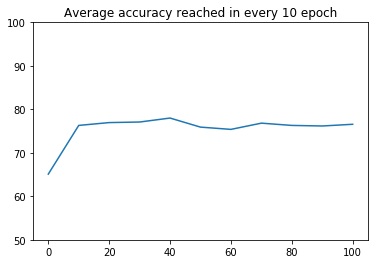

In [15]:
import matplotlib.pyplot as plt
x_axis = [epoch for epoch in range(0, max_epoch+10, 10)]
accuracy_plt = plt.plot(x_axis,epoch_score)
#plt.xlim(xmax = max_epoch, xmin = 0)
plt.ylim(ymax = 100, ymin = 50)
plt.title('Average accuracy reached in every 10 epoch')
print(accuracy_plt)

Use a different dataset to perform the logistic regression model with the defined functions above.

The dataset 'voice.csv' is used. The labels are indicating whether the gender of the voice is 'male' or 'female'. The first step is to remove the column header and change the labels to 1 or 0, with 1 representing 'male' and 0 representing 'female'.

Dataset can be found on: https://www.kaggle.com/primaryobjects/voicegender/

In [16]:
dataset_2 = load_csv('voice.csv')
col_names = dataset_2[0]
dataset_2.pop(0)
for row in dataset_2:
    if row[-1] =='male':
        row[-1]=1
    else:
        row[-1]=0

for i in range(len(dataset_2[0])-1):
    str_column_to_float(dataset_2, i)

minmax_data_2 = dataset_minmax(dataset_2)

normalize_dataset(dataset_2, minmax_data_2)

In [17]:
scores_list_2 = score_df(dataset_2)
results_2 = pd.DataFrame(scores_list_2, columns = ('k-fold', 'learning rate', 'epoch', 'average accuracy %', 'confusion matrix'))
print(results_2.tail())

    k-fold  learning rate  epoch  average accuracy %  confusion matrix
79       9           0.20    100           97.474747  [168, 3, 5, 176]
80       9           0.25     50           97.380051  [164, 6, 1, 181]
81       9           0.25    100           97.032828  [160, 7, 4, 181]
82       9           0.30     50           97.443182  [175, 6, 3, 168]
83       9           0.30    100           97.537879  [170, 3, 4, 175]


In [18]:
results_list_2 = find_max_accuracy(results_2)

k-fold, learning rate, epoch for max. average accuracy:  [5, 0.3, 100]
confusion matrix:  [320, 17, 4, 292]
Average accuracy obtained: 97.662 %
